# GoFish

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Correlation Analysis</a></li>
</ul>

<a id='intro'></a>
## Introduction
### Overview
**GoFish** reports Pearson's correlations between any number of targetted datasets.  

### Caveats
* This program is a reduction of a larger project. There may be some artifacts from that larger project that will need to be removed.
* Only CSV files are loaded as target datasets
* GoFish attempts to load all CSV files in a given directory
* The 'given directory' is hardcoded as **Data**
* Some hardcoding is present that makes this utility workable only with the **Example Dataset Source** files (below) 
* All CSV file datasets are assumed to have the following structure:
 * Column 1: country (regardless of column header)
 * Column 2-n: 4-digit year
* Exception and error handling is not included

### Example Dataset Source
Downloads from <a href source="https://www.gapminder.org/data/">Gapminder</a>

> Note: Gapminder data is sometimes based on very rough estimates or extrapolations. All data, statistics and visuals presented here should be considered generalizations only. 

#### Population
* Description: Total population
* Download: population_total.csv 

#### Income
* Description: Gross domestic product per person adjusted for differences in purchasing power (in international dollars, fixed 2011 prices, PPP based on 2011 ICP).
* Download: income_per_person_gdppercapita_ppp_inflation_adjusted.csv

#### Life expectancy (years)
* Description: The average number of years a newborn child would live if current mortality patterns were to stay the same.
* Download: life_expectancy_years.csv

#### Water, overall access (%)
* Description: The percentage of people using at least asic water services. This indicator encompasses both people using basic water services as well as those using safely managed water services. Basic drinking water services is defined as drinking water from an improved source, provided collection time is not more than 30 minutes for a round trip. Improved water sources include piped water, borholes or tubewells, protected dug wells, protected springs, and packaged or delivered water.
* Download: at_least_basic_water_source_overall_access_percent.csv
---

## Prepare Project Environment

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv
from os import listdir
from itertools import combinations

%matplotlib inline

Stylize Markdown cells

In [2]:
%%html
<style>
    table {
        display: inline-block;
    }
    .boxed {
        border: 1px solid grey;
        padding: 20px;
    }
    .alert-block {
        font-size: 1.5rem;
    }
    .alert-block p {
        margin-bottom: 20px;
    }
    .coral-box {
        background-color: #FFD3C2;
    }
    .blue-box {
        background-color: #DAE5F3;
    }
    .green-box {
        background-color: #DAF2E8;
    }
</style>

***

<a id='wrangling'></a>
## Data Wrangling

1. Find all the CSV files (datasets) in a given directory.
2. Load CSV data into dataframes.
3. Compile the dataframes into a dictionary. 
4. Inspect the data.

In [3]:
# Functions for this section

def find_csv_files (path_to_dir):
    """Return: List of filenames with suffix in path_to_dir."""
    return [filename for filename in listdir(path_to_dir) if filename.endswith( suffix )] 



def csv_dir_to_df_dict(path_to_dir):
    """Return dictionary of dataframes loaded with csv files in path_to_dir."""
    result_dict = {}
    
    for filename in find_csv_files(path_to_dir):
        # Include path with filename 
        fullname = ("{}/{}").format(path_to_dir, filename)
        
        # dataframe name = filename, trimmed of suffix.
        dfname = filename.rsplit(suffix)[0]
        
        result_dict[dfname] = pd.read_csv(fullname)
        
    return result_dict



def print_df_preview(dfname, df):
    """Print the first & last several rows & columns of a dataframe."""
    print('\n{}\n{} {} :\n\n{}'.format\
          ("="*50, dfname, \
           df.shape, \
           df[list(df.columns[0:3]) + list(df.columns[-3:])].iloc[[0,1,-2,-1]]\
          )) 
    
    
def print_dfdict_preview(df_dict):
    """Print preview of dataframes within a dictionary."""
    print('\nHead & Tail of DataFrame rows & columns:\n')
    [print_df_preview(dfname, df) for dfname, df in df_dict.items()]
    

Load CSV data into `datasets_full`, a dictionary of dataframes, one dataframe for each CSV file.

In [4]:
# Identify dataset by directory name
datasets = ['Data']

In [5]:
# Create dictionary of dataframes
suffix = '.csv'

datasets_full = {}
for dataset_path_to_dir in datasets:
    datasets_full.update(csv_dir_to_df_dict(dataset_path_to_dir))

All data is now loaded into `datasets_full`.

Let's preview the loaded data ...

In [6]:
# Preview a few rows & columns of each dataframe. Include their shapes.
print_dfdict_preview(datasets_full)


Head & Tail of DataFrame rows & columns:


income_per_person_gdppercapita_ppp_inflation_adjusted (193, 220) :

             geo  1800  1801   2016   2017   2018
0    Afghanistan   603   603   1740   1800   1870
1        Albania   667   667  11400  11900  12400
191       Zambia   663   665   3640   3750   3870
192     Zimbabwe   869   870   1860   1910   1950

life_expectancy_years (187, 220) :

             geo  1800  1801  2016  2017  2018
0    Afghanistan  28.2  28.2  58.0  58.4  58.7
1        Albania  35.4  35.4  77.7  77.9  78.0
185       Zambia  32.6  32.6  58.8  59.1  59.5
186     Zimbabwe  33.7  33.7  59.3  59.8  60.2

population_total (195, 220) :

             geo     1800     1801      2016      2017      2018
0    Afghanistan  3280000  3280000  34700000  35500000  36400000
1        Albania   410000   412000   2930000   2930000   2930000
193       Zambia   747000   747000  16600000  17100000  17600000
194     Zimbabwe  1090000  1090000  16200000  16500000  16900000

at_least

***
Clean the datasets to make it ready for analysis ...


### Data Cleaning

Before data cleaning starts:
* Create a dataframe called `meta_df` to itemize the dataframes.
* Simplify dataframe names.

Then clean and trim as follows:

> **Columns**: Each dataframe contains a row for each country, and a sequence of year columns. Standardize the name of the country column to 'country' and index on it.

> **Zeros and NaN**: Zero values are assumed to be years in which a statistic for a country was not gathered. Zeros can skew the data when calculating aggregates. For this reason, reset zero values to NaN.

> **Countries**: Not all dataframes contain the same set of countries.  Avoid attempting to draw correlation between country statistics when not all countries have recorded statistics by trimming dataframes so they share a common set of countries.

> **Years**: Not all dataframes contain the same range of years. Trim dataframes so they share a common range of years for consistent analysis.

#### Metadata
Create `meta_df` to itemize loaded datasets. 

In [7]:
# Initialize meta_df with dataframe names
meta_df = pd.DataFrame([dfname for dfname in datasets_full.keys()], \
                        columns=['dataframe'])

Dataframes were named with CSV filenames, which are long and wordy. Create shorter aliases in `meta_df`.  (TODO: Automate name abbreviations)

First, create an alias dictionary ...

In [8]:
# Make cut/paste code for creating alias dictionary, 
# which needs to be copied to the next cell
print('"'+'\n"'.join(str(key)+'":"'+str(key).split("_")[0]+'",' for key in datasets_full.keys()))

"income_per_person_gdppercapita_ppp_inflation_adjusted":"income",
"life_expectancy_years":"life",
"population_total":"population",
"at_least_basic_water_source_overall_access_percent":"at",


In [9]:
# Create alias dictionary
alias_di = {
    "income_per_person_gdppercapita_ppp_inflation_adjusted":"income", \
    "life_expectancy_years":"life", \
    "population_total":"population", \
    "at_least_basic_water_source_overall_access_percent":"water",
    }

Map the dataframe aliases to `meta_df` dataframe names and index on it.

In [10]:
meta_df['statistic'] = meta_df['dataframe'].map(alias_di)
meta_df.set_index('statistic', inplace=True)
meta_df

,dataframe
statistic,
income,income_per_person_gdppercapita_ppp_inflation_a...
life,life_expectancy_years
population,population_total
water,at_least_basic_water_source_overall_access_per...


***
Now rename dataframes using the aliases ...

In [11]:
# List original dataframe names
dflist = list(datasets_full.keys())

# rename dataframes with their statistic name (mapped in meta_df)
for df in dflist:
    datasets_full[meta_df[meta_df['dataframe'] == df].index[0]] = datasets_full.pop(df)

# Verify new dataframe (statistic) names
list(datasets_full.keys())

['income', 'life', 'population', 'water']

***
Data structures are ready. Start cleaning ...

#### Columns - Rename and Index
Standardize all dataframe Country columns to 'country', and make it the row index.

In [12]:
# function to rename/reindex
f = lambda df: (df.rename(columns={'geo':'country'}).set_index('country'))

# loop through dataframes
for dfname in list(datasets_full.keys()):
    datasets_full[dfname] = f(datasets_full[dfname])

In [13]:
# Confirm all indexes are 'country' 
# TODO: add error handling procedures
print('Are all dataframe indexes named "country"?')
'country' == np.unique(list(map(lambda k: datasets_full[k].index.name, (k for k in datasets_full.keys()))))[0]

Are all dataframe indexes named "country"?


True

Hard copy `datasets_full` (original data) to `datasets_trim` (clean this copy.)

In [14]:
datasets_trim = datasets_full.copy()

#### Zeros and NaN - Cleanup
Any Zero values are assumed to be placeholders for missing data. Since zero values can inadvertently skew aggregate calculations, reset them to NaN (null).

Afterwards, make sure there are now no rows completely empty.

In [15]:
# Functions for this section

def print_empties(dfname, df):
    """Return False if no zeros, True of any are found. Print columns and rows with Zero values."""
    result = False
    zero_count = (df[df.columns]==0).any(axis=1).sum()
    if zero_count:
        print('\n{}\n{}:'.format('='*50, dfname))
        print('{}\n'.format(df[df.isin([0]).any(axis=1)]))
        result = True
    return result
            
            

def print_if_all_nulls(df_dict):
    """Return None. Print report, listing any dataframes that have rows containing only null values."""
    found = False
    for dfname, df in datasets_trim.items():
        if pd.isnull(df).all(1).any():
            print('{} has row with all nulls.'.format(dfname))
            found = True
    if not found:
        print('No empty rows.')
    
    return None

Print any Zero values ...

In [16]:
print('DataFrame Rows with Zero Values:')
[print_empties(dfname, df) for dfname, df in datasets_trim.items()];

DataFrame Rows with Zero Values:

life:
                  1800  1801  1802  1803  1804  1805  1806  1807  1808  1809  \
country                                                                        
Andorra            0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
Dominica           0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
Marshall Islands   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   

                  ...   2009  2010  2011  2012  2013  2014  2015  2016  2017  \
country           ...                                                          
Andorra           ...   82.7  82.7  82.6  82.6  82.6  82.6  82.5  82.5   0.0   
Dominica          ...   73.4  73.0  73.0  72.9  72.7  72.7  71.7  73.0   0.0   
Marshall Islands  ...   63.5  63.7  63.9  64.1  64.3  64.5  64.7  65.0   0.0   

                  2018  
country                 
Andorra            NaN  
Dominica           NaN  
Marshall Islands   NaN  

[3 rows x 219 columns]


water:


It looks like there are only a few countries with Zero values, and even those have at least 5 years of data from which we can aggregate. Go ahead and translate all Zeros into NaNs ...

In [17]:
# Replace zeros with NaN, then drop any rows where all values are NaN. 
for dfname, df in datasets_trim.items():
    datasets_trim[dfname] = datasets_trim[dfname].replace({0:np.nan, 0.0:np.nan})
    datasets_trim[dfname] = datasets_trim[dfname].dropna(how='all')

In [18]:
# Verify there are no empty rows.
print_if_all_nulls(datasets_trim)

No empty rows.


TODO: more error handling here ... handle any non-empty rows.

Start trimming ...

#### Countries - Trim
Make sure dataframes share a common set of countries (inner join) by trimming any countries not shared by all dataframes.

First, identify the countries to be trimmed and list them in `meta_df` for reference.

In [19]:
# Create list of common countries.
dflist = list(datasets_trim.values())
common_countries_list = pd.concat(dflist, axis=1, join='inner').index

# Add uncommon countries (to be trimmed) to meta_df.
meta_df['excluded_countries'] = ""
for data_set, df in datasets_trim.items():
    meta_df.loc[data_set]['excluded_countries'] = [x for x in df.index if x not in common_countries_list]
    
# View the countries to be excluded.
pd.set_option('display.max_colwidth', -1)
meta_df

,dataframe,excluded_countries
statistic,,
income,income_per_person_gdppercapita_ppp_inflation_adjusted,"[Monaco, Nauru, Palau, San Marino, St. Kitts and Nevis, Tuvalu]"
life,life_expectancy_years,[]
population,population_total,"[Holy See, Liechtenstein, Monaco, Nauru, Palau, San Marino, St. Kitts and Nevis, Tuvalu]"
water,at_least_basic_water_source_overall_access_percent,"[Liechtenstein, Monaco, Nauru, Palau, San Marino, St. Kitts and Nevis, Tuvalu]"


***
TODO: add functionality to verify with the analyst that the above list is acceptable before trimming excluded countries.

Exclude non-common countries from dataframes.

In [20]:
for dfname, df in datasets_trim.items():
    datasets_trim[dfname] = df[df.index.isin(common_countries_list)]

Verify dataframe row counts match (confirming the same number of countries).

In [21]:
[print(df.shape[0], dfname) for dfname, df in datasets_trim.items()];

187 income
187 life
187 population
187 water


TODO: more automated exception handling here, verify working with a uniform set of countries.  

Trim year columns ...

#### Years - Trim
Verify a consistent range of years by finding a common range of years and trimming the rest.

In [22]:
# Functions for this section

def get_year_metadata(dict):
    """Return dataframe containing range of years."""
    result_df = pd.DataFrame()

    for dfname, df in dict.items():
        result_df[dfname] = [df.columns[0], df.columns[-1]]

    result_df = result_df.transpose()   
    result_df.rename(columns = {0:'first_year',1:'last_year'}, inplace=True)
    result_df.index.names = ['data_set']
    return result_df



def trim_df_dict(df_dict, col_list):
    """Return dictionary of dataframes, trimmed of columns not in col_list."""
    result_dict = {}
    for dfname, df in df_dict.items():
        keep_columns = [col for col in df_dict[dfname].columns if col in col_list]
        result_dict[dfname] = df_dict[dfname][keep_columns]
        
    return result_dict

Before trimming years, record the original year ranges to `meta_df` for reference, and report the Common Year Range.

In [23]:
meta_df = pd.concat([meta_df, get_year_metadata(datasets_trim)], axis=1)
meta_df[['first_year','last_year']]

,first_year,last_year
income,1800,2018
life,1800,2018
population,1800,2018
water,2000,2015


In [24]:
# Find common range
first_year, last_year = (meta_df['first_year'].max(), meta_df['last_year'].min())

# Confirm range of years
print('Common Year Range: {} -> {}\n'.format(first_year, last_year))

Common Year Range: 2000 -> 2015



TODO: more exception handling here.

Trim the years outside the Common Year Range.

In [25]:
years_in_range = [str(y) for y in list(range(int(first_year),int(last_year)+1))]
datasets_trim = trim_df_dict(datasets_trim, years_in_range)

At this point, dataframes should have the same shape (country rows and year columns). Verify this ... (TODO: automate the verification)

In [26]:
# Confirm trimmed datasets. Each dataset should have same year columns.
[print('{} <-- {}'.format(df.shape, dfname)) for dfname, df in datasets_trim.items()];

(187, 16) <-- income
(187, 16) <-- life
(187, 16) <-- population
(187, 16) <-- water


***
Dataframes should now clean and trim. 

***
<a id='eda'></a>
## Correlation Analysis

*** 
Use `datasets_trim` for these set of questions, since its dataframes have a consistent country list and range of years. 

Consider each dataset an individual 'factor'. 

TODO: make factor identification more flexible, such as multiple factors per dataset.

#### Prepare the data
Create two new structures:
* `dataset_stats` - dictionary of dataframes, similar to the `datasets_trim` dataframes but containing only the averages for each country. (Includes averages of factor statistics. TODO: drop if not needed.)

In [27]:

# Create dataset_stats (dictionary of dataframes of with country means)
dataset_stats = {}
for dfname, df in datasets_trim.items():
    dataset_stats[dfname] = df.transpose()\
                            .describe().loc[['mean']]\
                            .transpose()

In [28]:
# Create 2D array, a row for each stat: 
#   [[statistic name, statistic mean name]]
stats_arr = np.array([(stat, stat+"_mean") for stat in meta_df.index])
stats_arr

array([['income', 'income_mean'],
       ['life', 'life_mean'],
       ['population', 'population_mean'],
       ['water', 'water_mean']], dtype='<U15')

Let's get a quick glance at population distributions.

In [29]:
pd.options.display.float_format = '{:,.2f}'.format
dataset_stats['population'].describe()

,mean
count,187.00
mean,"35,914,184.86"
std,"134,636,842.28"
min,"52,368.75"
25%,"2,093,437.50"
50%,"7,769,375.00"
75%,"23,634,375.00"
max,"1,340,625,000.00"


Find the correlation between every pair of factor statistics. First, create the pairings ...

In [30]:
# Create tuple pairs of all our statistic (dataframe) combinations.
stat_list = list(datasets_trim.keys())
dataset_corrs = pd.DataFrame(columns=['size','this_stat','that_stat','r'])
combines = list(combinations(stat_list,2))

Now calculate the correlaltion coefficients ('r') for each pair ...

In [31]:
# Compute correlation coefficients against each statistic pair.
for stat_tuple in combines:
    this_stat = stat_tuple[0] 
    that_stat = stat_tuple[1]
    this_mean = dataset_stats[this_stat]['mean']
    that_mean = dataset_stats[that_stat]['mean']
    
    correlation = this_mean.corr(that_mean)
    dataset_corrs = dataset_corrs.append\
        ({'size':'all', \
          'this_stat':this_stat, \
          'that_stat':that_stat, \
          'r':correlation}, \
         ignore_index=True)  
        
print('Done')

Done


What are the correlation coefficients of each statistic pair?

In [32]:
dataset_corrs.sort_values(by=['r'])

,size,this_stat,that_stat,r
1,all,income,population,-0.05
3,all,life,population,0.02
5,all,population,water,0.03
2,all,income,water,0.52
0,all,income,life,0.61
4,all,life,water,0.82


It appears that population has little to no correlation with life expetancy, water access and income.

Let's visualize the pairings to simplify conceptualization ...

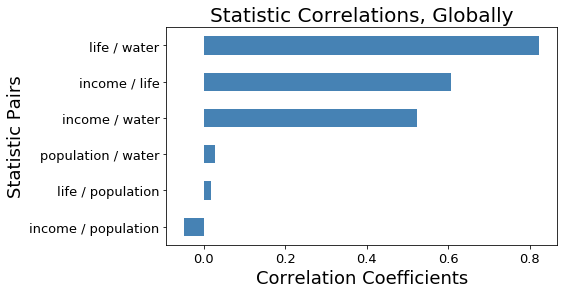

In [33]:
df = dataset_corrs[dataset_corrs['size'] == 'all']
x = df['r']
y = df['this_stat'].astype(str) + ' / ' + df['that_stat'].astype(str)
data = pd.concat([x,y], axis=1).set_index(0).rename_axis('this/that').sort_values(by='r')
ax = data['r'].plot(kind='barh',figsize=(7,4), fontsize=13, color='steelblue');
ax.set_title("Statistic Correlations, Globally", fontsize=20, color='black')
ax.set_xlabel("Correlation Coefficients", fontsize=18, color='black')
ax.set_ylabel("Statistic Pairs", fontsize=18, color='black');

***